In [165]:
import pandas as pd
from datetime import datetime, timedelta, date, time
from prophet import Prophet
from numpy import mean
from numpy import std

In [166]:
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

In [167]:
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
df = transactions.drop(['Value'], axis=1)
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df = df.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()

In [168]:
start_date = datetime(2021, 10, 17, 6, 0)
end_date = start_date + timedelta(minutes=AGG*100)
start_date, end_date

(datetime.datetime(2021, 10, 17, 6, 0),
 datetime.datetime(2021, 10, 18, 15, 20))

In [169]:
# df = df[start_date:end_date]['Price']
df = df.reset_index()

In [184]:
def y_lims(df, col_name):
    data_mean, data_std = mean(df[col_name]), std(df[col_name])
    cut_off = data_std * 5
    return data_mean - cut_off, data_mean + cut_off   

def cut_off(df, col_name):
    data_mean, data_std = mean(df[col_name]), std(df[col_name])
    cut_off = data_std * 2
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # print(data_mean, data_std, lower, upper)
    for index,row in df.iterrows():
        if row[col_name] < lower:
            row[col_name]=lower
        elif row[col_name] > upper:
            row[col_name]=upper

In [176]:
df.rename(columns = {'Date':'ds', 'Price': 'y'}, inplace=True)
df.head()

105861616526.50877 98067419763.33182 -90273223000.15486 301996456053.1724


,ds,y
0,2021-01-01 00:00:00,8.084088e+10
1,2021-01-01 00:20:00,8.024579e+10
2,2021-01-01 00:40:00,7.701433e+10
3,2021-01-01 01:00:00,8.713914e+10
4,2021-01-01 01:20:00,7.425917e+10


In [171]:
m = Prophet(changepoint_prior_scale=0.0005,yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

In [172]:
future = m.make_future_dataframe(periods=100, freq=FREQ)
future.tail()

,ds
21047,2021-10-20 07:40:00
21048,2021-10-20 08:00:00
21049,2021-10-20 08:20:00
21050,2021-10-20 08:40:00
21051,2021-10-20 09:00:00


In [173]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
21047,2021-10-20 07:40:00,1.173936e+11,1.160712e+10,2.232846e+11
21048,2021-10-20 08:00:00,1.188005e+11,7.174842e+09,2.266301e+11
21049,2021-10-20 08:20:00,1.202216e+11,6.517861e+09,2.300397e+11
21050,2021-10-20 08:40:00,1.214966e+11,9.878667e+09,2.253492e+11
21051,2021-10-20 09:00:00,1.225002e+11,1.855281e+10,2.323071e+11


(9820006758.496048, 202166089337.70728)


(9820006758.496048, 202166089337.70728)

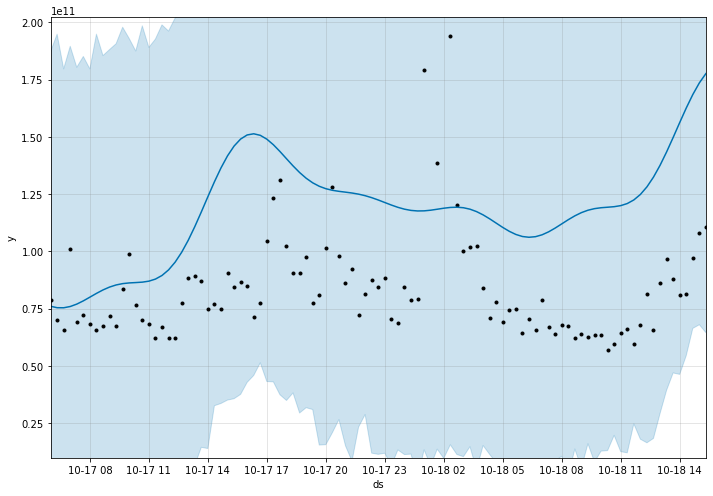

In [186]:
print(y_lims(forecast, 'yhat'))
fig = m.plot(forecast, figsize=(10, 7))
ax = fig.gca()
ax.set_xlim([start_date, end_date])
ax.set_ylim(y_lims(forecast, 'yhat'))